# Legalis scikit Predictor
#### Notebook used to create and publish an sckit-learn text classification modek for outcome prediction

## Libary and Dataset Import

#### install via pip (needed especially for only jupyter notebook services)

In [4]:
!pip install datasets
!pip install scikit-learn
!pip install nltk

#### imports

In [5]:
# standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

#nltk imports for stop words
import nltk
nltk.download('stopwords')

#sklearn import for model creation
from sklearn.feature_extraction.text import CountVectorizer #for vectorizing words
from sklearn.metrics import classification_report #for model evaluation
from sklearn.model_selection import train_test_split #for splitting dataset into test and train
from sklearn.naive_bayes import MultinomialNB #for naive bayes model used for comparison
from sklearn.ensemble import RandomForestClassifier #for random forest model used for prediction
from sklearn.model_selection import RandomizedSearchCV #for random forest tuning

#imports to pull/push to/from huggingface hub
import datasets as ds #for dataset import

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### importing dataset from huggingface (production way) or from local file (not recommended and commented out)

In [16]:
#loading dataset from csv (reproduction way)
#dataset=ds.load_dataset("csv", data_files="legalis-dataset.csv", split="train")

#loading dataset from huggingface hub (production way)
dataset=ds.load_dataset("lennardzuendorf/legalis")
dataset=ds.concatenate_datasets([dataset['train'], dataset['test']])
print(dataset)

Found cached dataset csv (C:/Users/lenna/.cache/huggingface/datasets/csv/default-9d276a5be705aa8e/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


Dataset({
    features: ['id', 'file_number', 'date', 'type', 'content', 'tenor', 'facts', 'reasoning', 'winner', 'label'],
    num_rows: 2801
})


#### cleaning dataset and renaming columns to limit clutter

In [17]:
#removing columns not needed for prediction
dataset=dataset.remove_columns(['id', 'file_number', 'date', 'type', 'content', 'tenor','reasoning'])

#renaming columns to make them more readable and comparable to other datasets
dataset=dataset.rename_column('facts', 'text')
dataset=dataset.rename_column('winner', 'target')

print(dataset)

Dataset({
    features: ['text', 'target', 'label'],
    num_rows: 2801
})


#### Exploring Dataset/Checking for Class Imbalance

Verklagte*r  Klaeger*in
case nmb.       1705.00     1096.00
case dist.         0.61        0.39

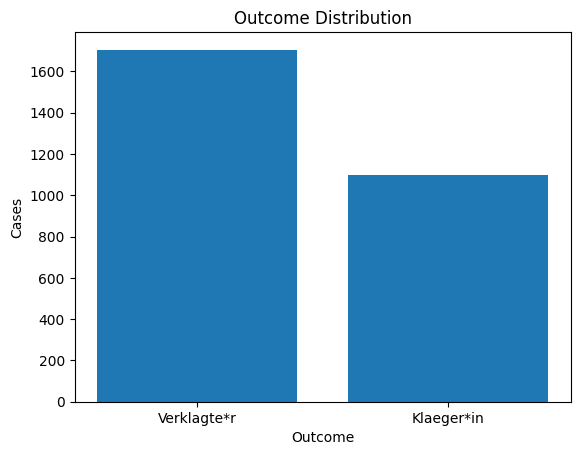

In [20]:
#checking for class imbalance
counter_zero=0
counter_one=0

#counting number of cases for each class
for case in dataset:
    if case['label']==1:
        counter_one+=1
    elif case['label']==0:
        counter_zero+=1

#calculating distribution of classes
dist=[round(counter_zero/(counter_zero+counter_one),2),round(counter_one/(counter_zero+counter_one),2)]

#creating column names and index for dataframe
data={'Verklagte*r': [counter_zero, dist[0]], 'Klaeger*in': [counter_one, dist[1]]}
index=['case nmb.', 'case dist.']

#creating dataframe and axis values
case_df = pd.DataFrame(data=data, index=index)
cases = case_df.columns
values = case_df.iloc[0]

#creating plot
fig, ax = plt.subplots()
ax.bar(cases, values)
ax.set_xlabel('Outcome')
ax.set_ylabel('Cases')
ax.set_title('Outcome Distribution')

#displaying data and plot
display(case_df)
plt.show()

**Comment:** There is a distinct class imbalance in the dataset. But in order to normalize this I would have needed to remove a lot of data from the dataset. This would have been a problem because the dataset is already very small. Therefore, I decided to keep the class imbalance and see how the model performs.

## Predifining Functions to run several times with different dataset sizes
#### function for dataframe creation with variable size and splitting into test, train

In [86]:
def create_dataset(size, test_size):

    #creating dataframe from dataset (given size) and splitting into test and train
    df_dataset=pd.DataFrame(dataset[:size])
    df_train, df_test = train_test_split(df_dataset, test_size=test_size)

    return df_train, df_test

#### function to vectorize words and get rid of german stopwords with nltk

In [87]:
#creating stopword list
from nltk.corpus import stopwords
stop_words=stopwords.words('german')

def vectorize_words_stop(df_train, df_test):

    #creating vectorizer
    vec = CountVectorizer(
        ngram_range=(1, 3),
        stop_words=stop_words,
    )

    #vectorizing words
    X_train = vec.fit_transform(df_train.text)
    X_test = vec.transform(df_test.text)

    y_train = df_train.target
    y_test = df_test.target

    return X_train, X_test, y_train, y_test

#### block with functions for fitting models and returning reports

In [88]:
#function for naive bayes model
def mulitmodel_fitter(X_train, y_train, X_test, y_test):

    #creating and fitting naive bayes model
    nb = MultinomialNB()
    nb.fit(X_train, y_train)

    #predicting and returning classification report
    predict = nb.predict(X_test)
    return classification_report(y_test, predict, output_dict=True)

#function for random forest model
def forest_fitter(X_train, y_train, X_test, y_test, config):

    #creating and fitting random forest model
    rf = RandomForestClassifier(random_state=0, **config)
    rf.fit(X_train, y_train)

    #predicting and returning classification report
    predict = rf.predict(X_test)
    return  classification_report(y_test, predict, output_dict=True)

#### block for the random forest tuning function with randomized search

In [89]:
def forest_tuner(X_train, y_train, n_iter, cv, random_state):

    #defining parameter grid for randomized search
    param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [None, 5, 10, 15],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4],
      'max_features': ['log2', 'sqrt'],
      'bootstrap': [True, False],
    }

    #running randomized search
    random_search = RandomizedSearchCV(
      estimator=RandomForestClassifier(),
      param_distributions=param_grid,
      n_iter=n_iter,
      cv=cv,
      random_state=random_state
    )

    #fitting model and returning best parameters and results
    random_search.fit(X_train, y_train)
    return random_search.best_params_, random_search.cv_results_


## Running Model with different dataset sizes
#### block with functions to run models with different sizes or with/without stop words

In [90]:
#function to run mutimodal model with different dataset sizes
def mutimodal_runner(run_list):
    output=[]

    #looping through different dataset sizes
    for run in run_list:

        #creating dataset and vectorizing words
        df_train, df_test = create_dataset(run, 0.2)
        X_train, X_test, y_train, y_test = vectorize_words_stop(df_train, df_test)

        #fitting model and appending report to output
        report = mulitmodel_fitter(X_train, y_train, X_test, y_test)
        output.append(report)

    return output

#function to run random forest model with different dataset sizes
def forest_runner(run_list, n_iter, cv, random_state):
    tuning_results=[]
    fitting_results=[]

    #looping through different dataset sizes
    for run in run_list:
        df_train, df_test = create_dataset(run, 0.2)
        X_train, X_test, y_train, y_test = vectorize_words_stop(df_train, df_test)

        #tuning and fitting model, appending results to output
        config, results=forest_tuner(X_train, y_train, n_iter, cv, random_state)
        tuning_results.append(results)

        #fitting model and appending report to output
        report = forest_fitter(X_train, y_train, X_test, y_test, config)
        fitting_results.append(report)

    #returning tuning and fitting results for further analysis
    return tuning_results, fitting_results

#### block with function to extract statistics from classification reports and plotting different reports

In [103]:
def stat_extractor(run_stats, run_nmbs):
    data={}
    i=0

    #creating row names for dataframe
    index=['precision Klaeger*in', 'precision Verklagte*r', 'overall accuracy', 'macro avg', 'weighted avg']

    #looping through reports and extracting statistics
    for run in run_stats:

        #extracting statistics and appending to output
        df=pd.DataFrame.from_dict(run)
        values = df.values[:1][0].round(decimals=3)
        run_data={str(run_nmbs[i]): values}
        data.update(run_data)
        i=i+1

    #returning dataframe with statistics of all runs
    return pd.DataFrame(data=data, index=index)

#function to plot fitting report for random forest and naive bayes
def fitting_plotter(run_stats, mode):

  #creating dataframe with statistics
  df = run_stats
  df_filtered = run_stats.drop("macro avg")

  #setting title depending on model
  if mode=='multimodal':
    title='naive bayes multimodal performance with different dataset sizes'
  else:
    title='random forest performance with different dataset sizes'

  #creating subplots and setting title
  fig, axs = plt.subplots(2, 2, figsize=(8, 8))
  fig.suptitle(title, fontsize=16)
  fig.tight_layout(pad=3.0)  # Adjust the padding between subplots
  axs = axs.flatten()

  #creating subplots for each metric
  for i, metric in enumerate(df_filtered.index[:4]):
      axs[i].plot(df.columns, df_filtered.loc[metric], marker='o')
      axs[i].set_title(metric)

  #setting labels
  for ax in axs:
      ax.set_xlabel('nmb. of cases')
  axs[0].set_ylabel('Precision')
  axs[1].set_ylabel('Accuracy')

  #displaying the plot
  plt.show()

#function to plot tuning report for random forest
def tuning_plotter(cv_results_list, run_nmbs):

    #initialize variables for number of runs and plots
    num_runs = len(cv_results_list)
    num_plots = num_runs

    #define number of rows and columns
    num_rows = int(np.ceil(np.sqrt(num_plots)))
    num_cols = int(np.ceil(num_plots / num_rows))

    #create subplots and set title
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    fig.suptitle(f"search test scores across {num_plots} runs with different dataset sizes", fontsize=16)
    fig.tight_layout(pad=3.0)

    #flatten the axs array if there is only one row or column
    if num_plots == 1:
        axs = np.array([axs])

    #looping through different runs
    for i, cv_results in enumerate(cv_results_list):

        #extracting test scores and creating x-axis values from cv_results
        test_scores = cv_results['mean_test_score']

        #creating x-axis values and setting row and column for subplot
        iteration_index = np.arange(1, len(test_scores) + 1)
        row = i // num_cols
        col = i % num_cols

        #creating scatter plot in subplot
        axs[row, col].scatter(iteration_index, test_scores)
        axs[row, col].set_xticks(range(0, len(test_scores) + 1, 1))
        axs[row, col].set_xlabel('Iteration')
        axs[row, col].set_ylabel('Test Score')
        axs[row, col].set_title(f'Run with {run_nmbs[i]} cases')

    #removing any unused subplots
    if num_plots < num_rows * num_cols:
        for i in range(num_plots, num_rows * num_cols):
            row = i // num_cols
            col = i % num_cols
            fig.delaxes(axs[row, col])

    #displaying the plot
    plt.show()

#### running and displaying stats for multimodal model with different dataset sizes

1000   2000   2400   2800
precision Klaeger*in   0.786  0.667  0.644  0.714
precision Verklagte*r  0.694  0.625  0.680  0.670
overall accuracy       0.700  0.628  0.677  0.673
macro avg              0.740  0.646  0.662  0.692
weighted avg           0.725  0.641  0.668  0.686

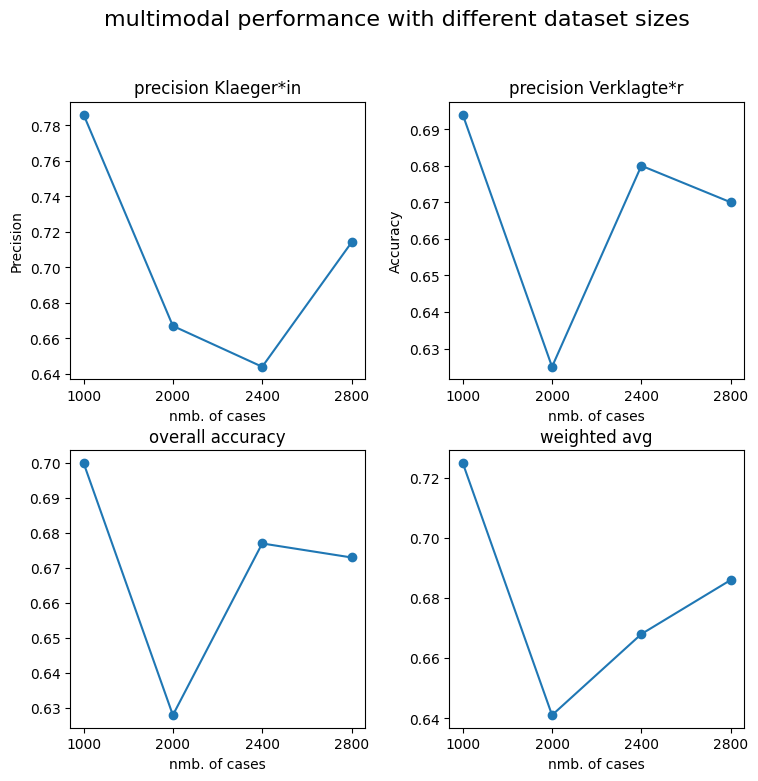

In [44]:
#running multimodal model with different dataset sizes
run_nmbs=[1000, 2000, 2400, 2800]
multimodal_run_stats=mutimodal_runner(run_nmbs)
multimodal_run_stats=stat_extractor(multimodal_run_stats, run_nmbs)

#displaying results and plotting
display(multimodal_run_stats)
fitting_plotter(multimodal_run_stats, mode="multimodal")

#### tuning and running random forest classifier for different data sizes, plotting results

1000   2000   2400   2800
precision Klaeger*in   1.000  0.824  0.793  0.875
precision Verklagte*r  0.653  0.569  0.627  0.638
overall accuracy       0.660  0.580  0.638  0.648
macro avg              0.827  0.696  0.710  0.757
weighted avg           0.778  0.683  0.693  0.729

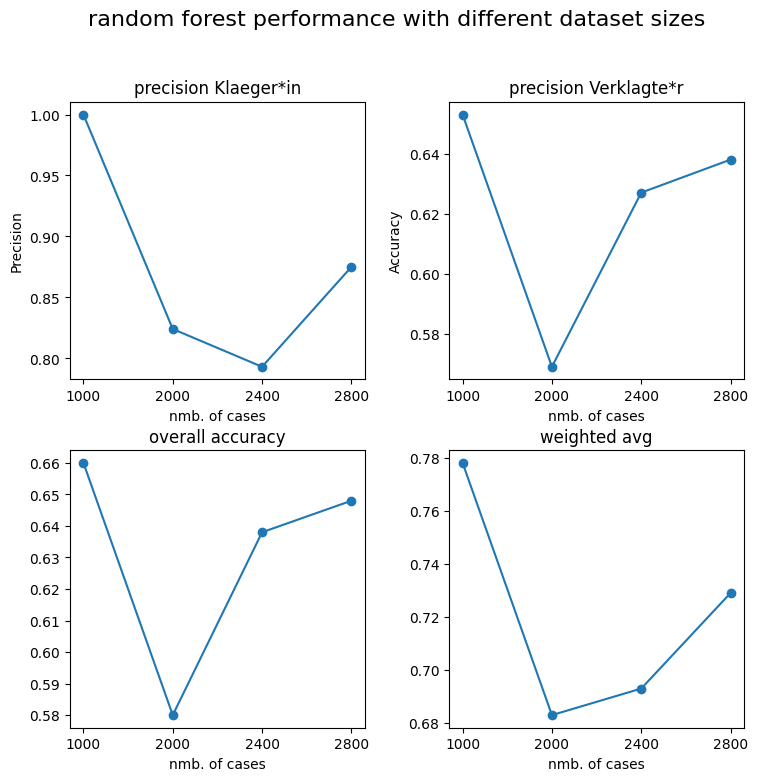

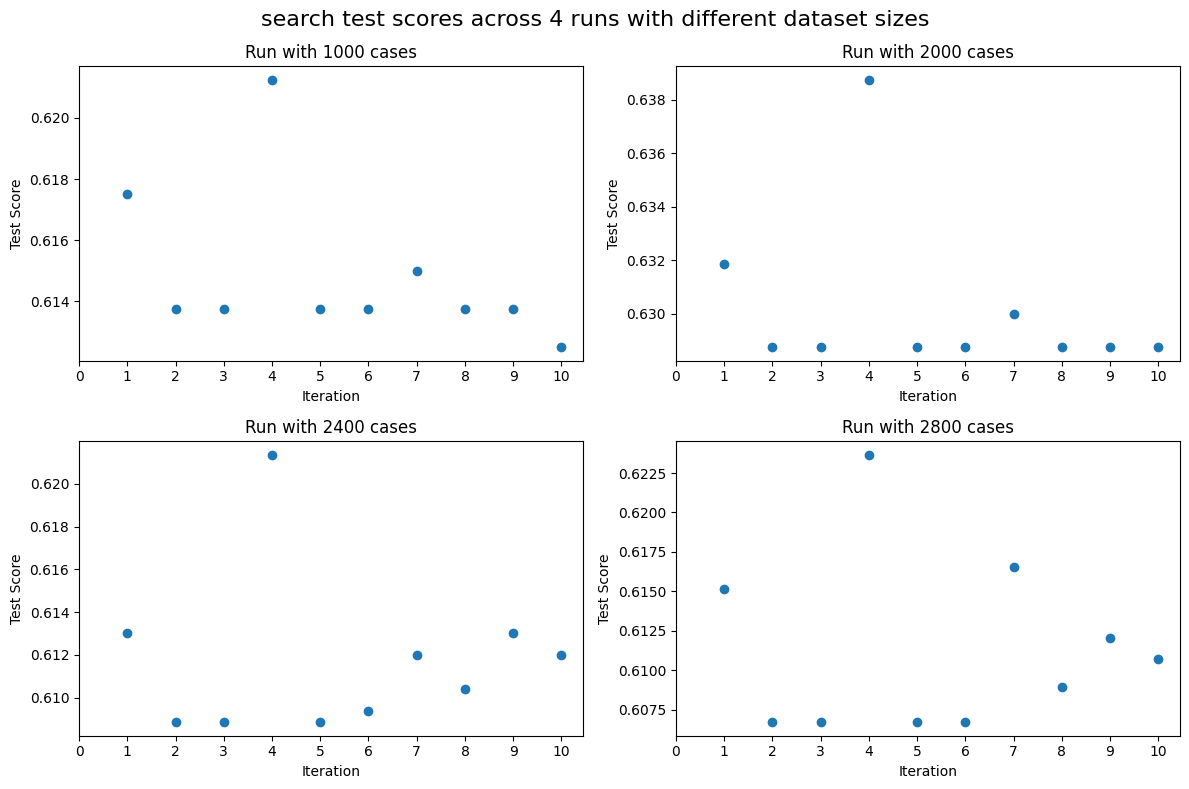

In [107]:
#fitting and running random forest classifier for different data sizes
run_nmbs=[1000, 2000, 2400, 2800]
tuning_results, fitting_results=forest_runner(run_nmbs, n_iter=10, cv=2, random_state=42)
fitting_results=stat_extractor(fitting_results, run_nmbs)

#displaying results and plotting
display(fitting_results)
print("\n")
fitting_plotter(fitting_results, mode="forest")
print("\n")
tuning_plotter(tuning_results, run_nmbs)

Comment: Although Random Forest is not prone to it, there seems to be a lot of overwriting or other calculation issues in the precision of one or the other label (see precision with 1000 cases), especially when working with smaller case numbers. I couldn't really make out why this is the case.